install this if needed before running the code
python3 -m pip install pypokerengine    
python3 -m pip install matplotlib     
python3 -m pip install torch    
python3 -m pip install rlcard tensorflow
python3 -m pip install scikit-learn

the poker environement is a library from github called RL Card
https://github.com/datamllab/rlcard/blob/master/docs/games.md

in the cell below we import what we need and create en environment


In [206]:
import argparse
import pprint

import rlcard
from rlcard.agents import RandomAgent
from rlcard.utils import set_seed
import numpy as np

# Make environment
env = rlcard.make(
    'no-limit-holdem',
    config={
        'seed': 42,
    }
)

# Seed numpy, torch, random
set_seed(42)

# Set agents
agent = RandomAgent(num_actions=env.num_actions)
env.set_agents([agent for _ in range(env.num_players)])

# Generate data from the environment
trajectories, player_wins = env.run(is_training=False)
# Print out the trajectories
print("we print this just to check if the code is working")
print('\nTrajectories:')
print(trajectories)
print('\nSample raw observation:')
pprint.pprint(trajectories[0][0]['raw_obs'])
print('\nSample raw legal_actions:')
pprint.pprint(trajectories[0][0]['raw_legal_actions'])
print('\nSample raw legal_stakes:')
#pprint.pprint(trajectories[0][0]['stakes'])



we print this just to check if the code is working

Trajectories:
[[{'legal_actions': OrderedDict([(0, None), (1, None), (3, None), (4, None)]), 'obs': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 2.]), 'raw_obs': {'hand': ['HK', 'D4'], 'public_cards': [], 'all_chips': [1, 2], 'my_chips': 1, 'legal_actions': [<Action.FOLD: 0>, <Action.CHECK_CALL: 1>, <Action.RAISE_POT: 3>, <Action.ALL_IN: 4>], 'stakes': [99, 98], 'current_player': 0, 'pot': 3, 'stage': <Stage.PREFLOP: 0>}, 'raw_legal_actions': [<Action.FOLD: 0>, <Action.CHECK_CALL: 1>, <Action.RAISE_POT: 3>, <Action.ALL_IN: 4>], 'action_record': [(0, <Action.RAISE_POT: 3>), (1, <Action.RAISE_POT: 3>), (0, <Action.ALL_IN: 4>), (1, <Action.FOLD: 0>)]}, 3, {'legal_actions': OrderedDict([(0, None), (1, None), (2, None), (3, None), (4, None)]), 'obs

now we create a agent that will always call what the oponnent does
the idea si the have a baseline for a player that use a simple strategy 

In [207]:


class Always_Call_Agent(object):
    ''' A random agent. Random agents is for running toy examples on the card games
    '''

    def __init__(self, num_actions):
        ''' Initilize the random agent

        Args:
            num_actions (int): The size of the ouput action space
        '''
        self.use_raw = False
        self.num_actions = num_actions

    @staticmethod
    def step(state):
        ''' Predict the action given the curent state in gerenerating training data.

        Args:
            state (dict): An dictionary that represents the current state

        Returns:
            action (int): The action predicted (randomly chosen) by the random agent
        '''
        #stage = state['raw_obs']['stage'].name   # The current stage of the game preflop flop, turn or river
        #print('stage:', stage)
        #myhand = state['raw_obs']['hand']
        #print('myhand:', myhand)
        # public_cards = state['raw_obs']['public_cards']
        # print('public_card:', public_cards)
        #stake = state['raw_obs']['stakes']
        #print('stake:', stake)
        
        possible_actions = list(state['legal_actions'].keys())  # 0 fold, 1 check/call, 2 raise half pot, 3 raise pot, 4 all in
        if (2 in possible_actions) :
            return 2
        elif (3 in possible_actions) :
            return 3
        else:
            return 1
        # myaction = list(state['legal_actions'].keys())
        # print(np.random.choice(list(state['legal_actions'].keys())))
        # print('********************')
        # return np.random.choice(list(state['legal_actions'].keys()))

    def eval_step(self, state):
        ''' Predict the action given the current state for evaluation.
            Since the random agents are not trained. This function is equivalent to step function

        Args:
            state (dict): An dictionary that represents the current state

        Returns:
            action (int): The action predicted (randomly chosen) by the random agent
            probs (list): The list of action probabilities
        '''
        probs = [0 for _ in range(self.num_actions)]
        for i in state['legal_actions']:
            probs[i] = 1/len(state['legal_actions'])

        info = {}
        info['probs'] = {state['raw_legal_actions'][i]: probs[list(state['legal_actions'].keys())[i]] for i in range(len(state['legal_actions']))}

        return self.step(state), info
    
    def feed(self, ts):
        return None


Function to detect if we have a certain type of hand (useful for later)

In [208]:
def is_suited_connector(hand):
    suits = [card[0] for card in hand]
    value_ranks = {'2': 0, '3': 1, '4': 2, '5': 3, '6': 4, '7': 5, '8': 6, '9': 7, 'T': 8, 'J': 9, 'Q': 10, 'K': 11, 'A': 12}
    values = sorted([card[1:] for card in hand], key=lambda x: value_ranks[x[0] if len(x) == 2 else x])
    
    if len(set(suits)) == 1:  # Check if all cards are of the same suit
        for i in range(len(values) - 1):
            if value_ranks[values[i][0] if len(values[i]) == 2 else values[i]] + 1 == value_ranks[values[i+1][0] if len(values[i+1]) == 2 else values[i+1]]:
                return True  # Found suited connectors
    return False  # Not suited connectors

# Test the function
#hand1 = ['H4', 'H5']  # Suited connectors
#hand2 = ['ST', 'S9']  # Suited connectors
#hand3 = ['C9', 'D8']  # Not suited connectors
#hand4 = ['HQ', 'HK']  # Not suited connectors

#print("Hand 1 is suited connectors:", is_suited_connector(hand1))
#print("Hand 2 is suited connectors:", is_suited_connector(hand2))
#print("Hand 3 is suited connectors:", is_suited_connector(hand3))
#print("Hand 4 is suited connectors:", is_suited_connector(hand4))

Now we create a agent that play some kind of optimal strategie to see if the reinforcement learning algorithm can be better or at least equal

In [209]:
from collections import Counter


class SpecialAgent(object):
    ''' A random agent. Random agents is for running toy examples on the card games
    '''

    def __init__(self, num_actions):
        ''' Initilize the random agent

        Args:
            num_actions (int): The size of the ouput action space
        '''
        self.use_raw = False
        self.num_actions = num_actions

    @staticmethod
    def step(state):
       
        myhand = state['raw_obs']['hand']
        #stakes = state['raw_obs']['stakes']
        values = [card[1:] for card in myhand]
        value_counts = {value: values.count(value) for value in values}
        possible_actions = list(state['legal_actions'].keys())  # 0: fold, 1: call, 2: raise half pot, 4: all in

        #public_cards = state['raw_obs']['public_cards']   # if public_cards is empty, it is preflop
        stage = state['raw_obs']['stage'].name   # The current stage of the game preflop flop, turn or river

        if stage =="PREFLOP" and (
                any(count >= 2 for count in value_counts.values()) 
                or 'A' in values 
                or is_suited_connector(myhand) ):
                #or any(hand[1:] in combo for hand in myhand for combo in ['KQ', 'KJ', 'KT', 'QJ', 'QT', 'JT'])
                #or any(myhand[0][1] == card[1] for card in myhand)):
            if 3 in possible_actions:
                #print("raise pot", myhand[0][1], myhand[1][1], stakes)
                return 3
            else:
                #print("call ", myhand, stakes )
                return 1
        # flop
        elif stage =="FLOP" :
            if 3 in possible_actions:
                #print("raise pot", myhand[0][1], myhand[1][1])
                return 3
            else:
                return 1    
        # turn
        elif stage =="TURN" :  
            if 3 in possible_actions:
                return 3
            else:
                return 1
        # river
        elif stage =="RIVER" :  
            if 3 in possible_actions:
                return 3
            else:
                return 1

        else:
            return 0

        # public_cards = state['raw_obs']['public_cards']
        # print('myhand:', myhand)
        # print('public_card:', public_cards)
        # print('********************')

        # myaction = list(state['legal_actions'].keys())
        # print(np.random.choice(list(state['legal_actions'].keys())))
        # print('********************')
        # return np.random.choice(list(state['legal_actions'].keys()))

    def eval_step(self, state):
        ''' Predict the action given the current state for evaluation.
            Since the random agents are not trained. This function is equivalent to step function

        Args:
            state (dict): An dictionary that represents the current state

        Returns:
            action (int): The action predicted (randomly chosen) by the random agent
            probs (list): The list of action probabilities
        '''
        probs = [0 for _ in range(self.num_actions)]
        for i in state['legal_actions']:
            probs[i] = 1/len(state['legal_actions'])

        info = {}
        info['probs'] = {state['raw_legal_actions'][i]: probs[list(state['legal_actions'].keys())[i]] for i in range(len(state['legal_actions']))}

        return self.step(state), info
    
    def feed(self, ts):
        return None


Now we can see the performance of the agent that will play against players that play randomly 

--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  2.035
----------------------------------------
INFO - Step 100, rl-loss: 389.4891052246094
INFO - Copied model parameters to target network.
INFO - Step 169, rl-loss: 1262.0145263671875
----------------------------------------
  episode      |  100
  reward       |  3.5645
----------------------------------------
INFO - Step 332, rl-loss: 316.91400146484375
----------------------------------------
  episode      |  200
  reward       |  1.901
----------------------------------------
INFO - Step 507, rl-loss: 1893.7307128906255
----------------------------------------
  episode      |  300
  reward       |  1.6405
----------------------------------------
INFO - Step 657, rl-loss: 1552.3599853515625
----------------------------------------
  episode      |  400
  reward       |  2.9295
----------------------------------------
INFO - Step 832, rl-loss: 958.70324707031255
----------------

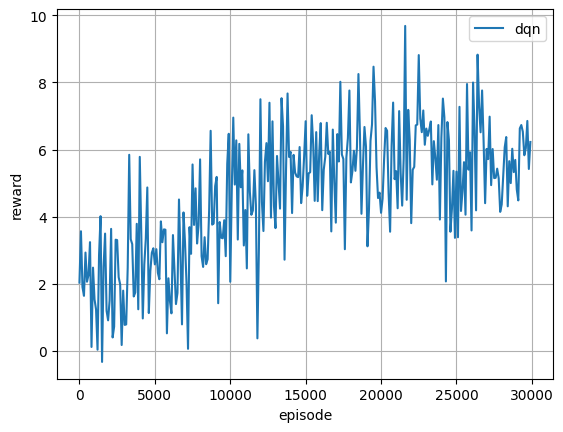

In [211]:
import os
#import argparse

import torch

import rlcard
from rlcard.agents import RandomAgent
from rlcard.utils import (
    get_device,
    set_seed,
    tournament,
    reorganize,
    Logger,
    plot_curve,
    
)

seed = 42

# Check whether gpu is available
device = get_device()
game_name = 'no-limit-holdem'
algorithm = 'dqn'           #change the algorithm by dqn, Always_Call, Special
log_dir = './logs/'
num_episodes = 30000
evaluate_every = 100
num_eval_games = 2000         #
    
# Seed numpy, torch, random
set_seed(seed)

# Make the environment with seed
env = rlcard.make(
    game_name,
    config={
        'seed': seed
    }
)

# Initialize the agent and use random agents as opponents
if algorithm == 'dqn':
    from rlcard.agents import DQNAgent
    agent = DQNAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        mlp_layers=[64,64],
        device=device,
    )
elif algorithm == 'nfsp':
    from rlcard.agents import NFSPAgent
    agent = NFSPAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        hidden_layers_sizes=[64,64],
        q_mlp_layers=[64,64],
        device=device,
    )
elif algorithm == 'Always_Call':
    agent = Always_Call_Agent(num_actions=env.num_actions)

elif algorithm == 'Special':
    agent = SpecialAgent(num_actions=env.num_actions)
    

agents = [agent]
for _ in range(1, env.num_players):
    agents.append(RandomAgent(num_actions=env.num_actions))
env.set_agents(agents)


hand_played = []

# Start training
with Logger(log_dir) as logger:
    for episode in range(num_episodes):

        if algorithm == 'nfsp':
            agents[0].sample_episode_policy()

        # Generate data from the environment
        trajectories, payoffs = env.run(is_training=True)

        # Reorganaize the data to be state, action, reward, next_state, done
        trajectories = reorganize(trajectories, payoffs)

        # Feed transitions into agent memory, and train the agent
        # Here, we assume that DQN always plays the first position
        # and the other players play randomly (if any)
        for ts in trajectories[0]:
            agent.feed(ts)

        # Evaluate the performance. Play with random agents.
        if episode % evaluate_every == 0:
            logger.log_performance(
                episode,
                tournament(
                    env,
                    num_eval_games,
                )[0]
            )
        for ts in trajectories[0]:
            #if (ts[0]['raw_obs']['stage'].name == "PREFLOP"):
            #    folded_hands_played.append(ts[3]['action_record'][-1][1].name)
            #    raise_hands_played.append(ts[3]['action_record'][-1][1].name)
            #elif (len(ts[0]['raw_obs']['public_cards']) == 0 and ts[3]['action_record'][-1][1].name != "FOLD" and ts[3]['raw_obs']['stage'].name == "RIVER"):
                #print(ts[0]['raw_obs']['hand'],ts[3]['action_record'][-1][1].name)
                #print(ts[0]['raw_obs']['hand'])
            hand_played.append((ts[0]['raw_obs']['hand'],ts[3]['action_record'][-1][1].name, ts[0]['raw_obs']['stage'].name, ts[0]['raw_obs']['stakes'], ts[0]['raw_obs']['legal_actions'] ))
                #hand_played.append((ts[0]['raw_obs']['hand'], ts[0]['raw_obs']['legal_actions']))
                #print(ts[0]['raw_obs']['hand'])


    # Get the paths
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the learning curve
plot_curve(csv_path, os.path.join(log_dir, f'{algorithm}_curve.png'), algorithm)

# Save model
save_path = os.path.join(log_dir, f'{algorithm}_model.pth')
torch.save(agent, save_path)
print('Model saved in', save_path)



We determine the regression with the optimal coeficient below

In [212]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load CSV data
data = np.loadtxt(csv_path, delimiter=",", skiprows=1)
x = data[:, 0]
y = data[:, 1]
# Split data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Try different polynomial degrees
degrees = range(1, 6)  # Try degrees from 1 to 5
best_degree = None
best_mse = float('inf')

for degree in degrees:
    # Fit polynomial regression
    coefficients = np.polyfit(x_train, y_train, degree)
    polynomial = np.poly1d(coefficients)

    # Evaluate on validation set
    y_pred = polynomial(x_val)
    mse = mean_squared_error(y_val, y_pred)
    
    # Update best degree if this degree performs better
    if mse < best_mse:
        best_mse = mse
        best_degree = degree

# Use the best degree to fit the final model
coefficients = np.polyfit(x, y, best_degree)
polynomial = np.poly1d(coefficients)
print('Best degree:', best_degree)


Best degree: 4


We add the regression line to avoid the huge variance due to the luck in poker

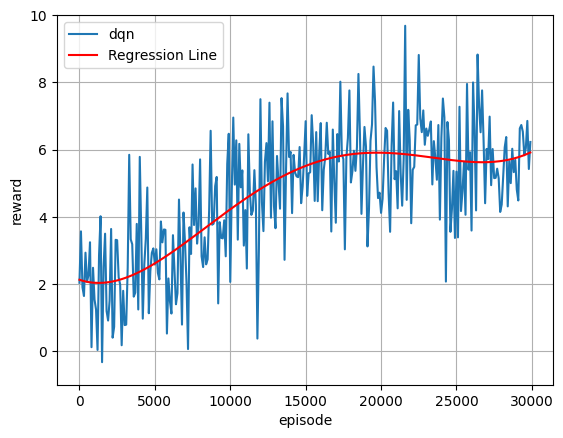

In [213]:
# Load CSV data
data = np.loadtxt(csv_path, delimiter=",", skiprows=1)

# Calculate regression line

coefficients = np.polyfit(x, y, best_degree)         
polynomial = np.poly1d(coefficients)
y_reg = polynomial(x)

# Plot learning curve
plot_curve(csv_path, fig_path, algorithm)

# Plot regression line
plt.plot(x, y_reg, color='r', label='Regression Line')
plt.ylim(-1, 10)  # Set y-axis limits
plt.legend()

# Save the combined plot to a different file
combined_fig_path = os.path.join(log_dir, f'{algorithm}_combined_plot.png')
plt.savefig(combined_fig_path)
plt.show()  # Show the plot after saving
plt.close()

what the model did the model do during the training ?


In [222]:
#folded_hands_played_last = folded_hands_played[-800:]
#folded_hands_played_begin = folded_hands_played[:800]

hands_only = [action[0] for action in hand_played] # Extract the hands played
action_made = [action[1] for action in hand_played] # Extract the actions made FOLD, CHECK_CALL, ...
stage_played = [action[2] for action in hand_played] # Extract the stage of the game PREFLOP, FLOP, TURN, RIVER
stakes_played = [action[3] for action in hand_played] # Extract the stakes played

print("During the all the training, the model has a:")
# Calculate the ratio of calling hands  played
raise_ratio_call = action_made.count("CHECK_CALL") / len(action_made)
print("Ratio of call hands played:", raise_ratio_call)
# Calculate the ratio of folded hands played
raise_ratio_fold = action_made.count("FOLD") / len(action_made)
print("Ratio of fold hands played:", raise_ratio_fold)
# Calculate the ratio of raised hands played
raise_ratio_raise = action_made.count("RAISE_POT") / len(action_made)
print("Ratio of raise hands played:", raise_ratio_raise)
# Calculate the ratio of all in hands played
raise_ratio_allin = action_made.count("ALL_IN") / len(action_made)
print("Ratio of all in hands played:", raise_ratio_allin)
print("\n")

hands_only = [action[0] for action in hand_played[:1000]] # Extract the hands played
action_made = [action[1] for action in hand_played[:1000]] # Extract the actions made FOLD, CHECK_CALL, ...
stage_played = [action[2] for action in hand_played[:1000]] # Extract the stage of the game PREFLOP, FLOP, TURN, RIVER
stakes_played = [action[3] for action in hand_played[:1000]] # Extract the stakes played

print("During the beggining of the training for the first 1000 hands, the model has a:")
# Calculate the ratio of calling hands  played
raise_ratio_call = action_made.count("CHECK_CALL") / len(action_made)
print("Ratio of call hands played:", raise_ratio_call)
# Calculate the ratio of folded hands played
raise_ratio_fold = action_made.count("FOLD") / len(action_made)
print("Ratio of fold hands played:", raise_ratio_fold)
# Calculate the ratio of raised hands played
raise_ratio_raise = action_made.count("RAISE_POT") / len(action_made)
print("Ratio of raise hands played:", raise_ratio_raise)
# Calculate the ratio of all in hands played
raise_ratio_allin = action_made.count("ALL_IN") / len(action_made)
print("Ratio of all in hands played:", raise_ratio_allin)
print("\n")

hands_only = [action[0] for action in hand_played[-1000:]] # Extract the hands played
action_made = [action[1] for action in hand_played[-1000:]] # Extract the actions made FOLD, CHECK_CALL, ...
stage_played = [action[2] for action in hand_played[-1000:]] # Extract the stage of the game PREFLOP, FLOP, TURN, RIVER
stakes_played = [action[3] for action in hand_played[-1000:]] # Extract the stakes played
print("During the end of the training for the last 1000 hands, the model has a:")
# Calculate the ratio of calling hands  played
raise_ratio_call = action_made.count("CHECK_CALL") / len(action_made)
print("Ratio of call hands played:", raise_ratio_call)
# Calculate the ratio of folded hands played
raise_ratio_fold = action_made.count("FOLD") / len(action_made)
print("Ratio of fold hands played:", raise_ratio_fold)
# Calculate the ratio of raised hands played
raise_ratio_raise = action_made.count("RAISE_POT") / len(action_made)
print("Ratio of raise hands played:", raise_ratio_raise)
# Calculate the ratio of all in hands played
raise_ratio_allin = action_made.count("ALL_IN") / len(action_made)
print("Ratio of all in hands played:", raise_ratio_allin)
print("\n")

During the all the training, the model has a:
Ratio of call hands played: 0.4392447764276617
Ratio of fold hands played: 0.5607552235723383
Ratio of raise hands played: 0.0
Ratio of all in hands played: 0.0


During the beggining of the training for the first 1000 hands, the model has a:
Ratio of call hands played: 0.245
Ratio of fold hands played: 0.755
Ratio of raise hands played: 0.0
Ratio of all in hands played: 0.0


During the end of the training for the last 1000 hands, the model has a:
Ratio of call hands played: 0.427
Ratio of fold hands played: 0.573
Ratio of raise hands played: 0.0
Ratio of all in hands played: 0.0




In [214]:
import matplotlib.pyplot as plt

def plot_single_hand(hand, save_path):
    plt.figure()
    plt.bar(hand['player'], hand['player'].values(), color='blue')
    plt.xlabel('Player')
    plt.ylabel('Number of chips')
    plt.title('Last Hand')
    plt.savefig(save_path)
    plt.close()


Check which hands was played during each training

In [223]:
from collections import Counter
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
import os



# Flatten the list of lists
all_hands = [hand for sublist in hands_only for hand in sublist]

# Count the frequency of each hand
hand_counts = Counter(all_hands)

# Create bar plot data
data = go.Bar(
    x=list(hand_counts.keys()),
    y=list(hand_counts.values()),
    marker=dict(color='rgb(65, 131, 215)')
)

# Layout settings
layout = go.Layout(
    title='Frequency of Each Hand Played during the Flop',
    xaxis=dict(title='Hand'),
    yaxis=dict(title='Frequency'), 
    margin=dict(b=100),
)

# Create figure
fig = go.Figure(data=[data], layout=layout)

# Save the plot
plot_path = os.path.join(log_dir, f'{algorithm}_hand_frequency.html')
pio.write_html(fig, plot_path)

print('Frequency plot saved in', plot_path)


Frequency plot saved in ./logs/dqn_hand_frequency.html


In [224]:
from collections import Counter
import plotly.graph_objs as go
import plotly.io as pio
import os

# Function to check if the hand is a pair
def is_pair(hand):
    return len(hand) == 2 and len(hand[0]) > 1 and len(hand[1]) > 1 and hand[0][1] == hand[1][1]

# Function to check if 'A' is in one of the two cards
def has_ace(hand):
    return len(hand) == 2 and ((len(hand[0]) > 1 and 'A' in hand[0][1:]) or (len(hand[1]) > 1 and 'A' in hand[1][1:]))

# Function to check if the hand is a suited connector
def is_suited_connector(hand):
    if len(hand) != 2:
        return False
    suits = {'H', 'D', 'C', 'S'}
    ranks = {'2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K', 'A'}
    return hand[0][0] == hand[1][0] and (len(hand[0]) > 1 and hand[0][1:] in ranks) and (len(hand[1]) > 1 and hand[1][1:] in ranks)

# Function to check if the hand has specific combinations
def has_specific_combination(hand):
    ranks = {'KQ', 'KJ', 'KT', 'QJ', 'QT', 'JT'}
    return len(hand) == 2 and hand[0][1:] in ranks and hand[1][1:] in ranks

# Initialize counters
pair_count = 0
ace_count = 0
suited_connector_count = 0
specific_combinations_count = 0
others_count = 0

# Categorize hands
for hands in hands_only:
    if is_pair(hands):
        pair_count += 1
    elif has_ace(hands):
        ace_count += 1
    elif is_suited_connector(hands):
        suited_connector_count += 1
    elif has_specific_combination(hands):
        specific_combinations_count += 1
    else:
        others_count += 1

# Create data for the pie chart
labels = ['Pairs', "'A' in one card", 'Suited Connectors', 'Specific Combinations', 'Others']
values = [pair_count, ace_count, suited_connector_count, specific_combinations_count, others_count]

# Create the pie chart
data = go.Pie(labels=labels, values=values)

# Create layout
layout = go.Layout(
    title='Frequency of Each Type of Hand Played during the Flop'
)

# Create figure
fig = go.Figure(data=[data], layout=layout)

# Save the plot
plot_path = os.path.join(log_dir, f'{algorithm}_hand_type_frequency.html')
pio.write_html(fig, plot_path)

print('Frequency plot saved in', plot_path)

# Open the saved HTML file in Visual Studio Code
#webbrowser.open(plot_path)


Frequency plot saved in ./logs/dqn_hand_type_frequency.html


Now we compare these results with a adversary that will always call
The goal is to see if the model end up with a better strategy than a dumb strategy

--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  8.1645
----------------------------------------

----------------------------------------
  episode      |  100
  reward       |  8.612
----------------------------------------

----------------------------------------
  episode      |  200
  reward       |  8.502
----------------------------------------

----------------------------------------
  episode      |  300
  reward       |  4.8285
----------------------------------------

----------------------------------------
  episode      |  400
  reward       |  7.914
----------------------------------------

----------------------------------------
  episode      |  500
  reward       |  6.657
----------------------------------------

----------------------------------------
  episode      |  600
  reward       |  5.294
----------------------------------------

----------------------------------------
  episode      |  700
  reward  

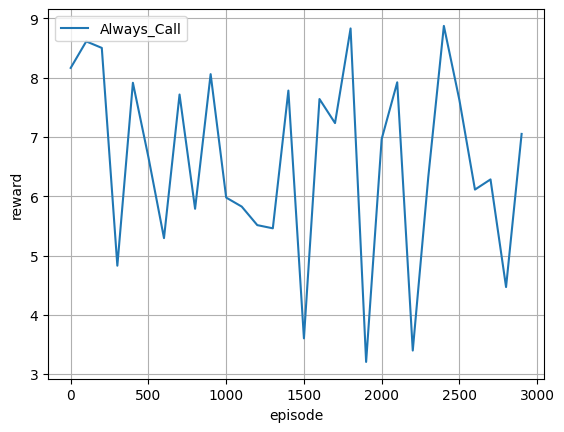

In [225]:
seed = 42

# Check whether gpu is available
device = get_device()
game_name = 'no-limit-holdem'
algorithm = 'Always_Call'           #change the algorithm by dqn, Always_Call, Special
log_dir = './logs/'
num_episodes = 3000
evaluate_every = 100
num_eval_games = 2000         #
    
# Seed numpy, torch, random
set_seed(seed)

# Make the environment with seed
env = rlcard.make(
    game_name,
    config={
        'seed': seed
    }
)

# Initialize the agent and use random agents as opponents
if algorithm == 'dqn':
    from rlcard.agents import DQNAgent
    agent = DQNAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        mlp_layers=[64,64],
        device=device,
    )
elif algorithm == 'nfsp':
    from rlcard.agents import NFSPAgent
    agent = NFSPAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        hidden_layers_sizes=[64,64],
        q_mlp_layers=[64,64],
        device=device,
    )
elif algorithm == 'Always_Call':
    agent = Always_Call_Agent(num_actions=env.num_actions)

elif algorithm == 'Special':
    agent = SpecialAgent(num_actions=env.num_actions)
    

agents = [agent]
for _ in range(1, env.num_players):
    agents.append(RandomAgent(num_actions=env.num_actions))
env.set_agents(agents)


hand_played = []
#folded_hands_played = []
#raise_hands_played = []
# Start training
with Logger(log_dir) as logger:
    for episode in range(num_episodes):

        if algorithm == 'nfsp':
            agents[0].sample_episode_policy()

        # Generate data from the environment
        trajectories, payoffs = env.run(is_training=True)

        # Reorganaize the data to be state, action, reward, next_state, done
        trajectories = reorganize(trajectories, payoffs)

        # Feed transitions into agent memory, and train the agent
        # Here, we assume that DQN always plays the first position
        # and the other players play randomly (if any)
        for ts in trajectories[0]:
            agent.feed(ts)

        # Evaluate the performance. Play with random agents.
        if episode % evaluate_every == 0:
            logger.log_performance(
                episode,
                tournament(
                    env,
                    num_eval_games,
                )[0]
            )
        # Check if it's preflop and player didn't fold
        for ts in trajectories[0]:
            #if (ts[0]['raw_obs']['stage'].name == "PREFLOP"):
            #    folded_hands_played.append(ts[3]['action_record'][-1][1].name)
            #    raise_hands_played.append(ts[3]['action_record'][-1][1].name)
            #elif (len(ts[0]['raw_obs']['public_cards']) == 0 and ts[3]['action_record'][-1][1].name != "FOLD" and ts[3]['raw_obs']['stage'].name == "RIVER"):
                #print(ts[0]['raw_obs']['hand'],ts[3]['action_record'][-1][1].name)
                #print(ts[0]['raw_obs']['hand'])
            hand_played.append((ts[0]['raw_obs']['hand'],ts[3]['action_record'][-1][1].name, ts[0]['raw_obs']['stage'].name, ts[0]['raw_obs']['stakes'], ts[0]['raw_obs']['legal_actions'] ))
                #hand_played.append((ts[0]['raw_obs']['hand'], ts[0]['raw_obs']['legal_actions']))
                #print(ts[0]['raw_obs']['hand'])




    # Get the paths
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the learning curve
plot_curve(csv_path, os.path.join(log_dir, f'{algorithm}_curve.png'), algorithm)

# Save model
save_path = os.path.join(log_dir, f'{algorithm}_model.pth')
torch.save(agent, save_path)
print('Model saved in', save_path)



We add a regression line to avoid the huge variance

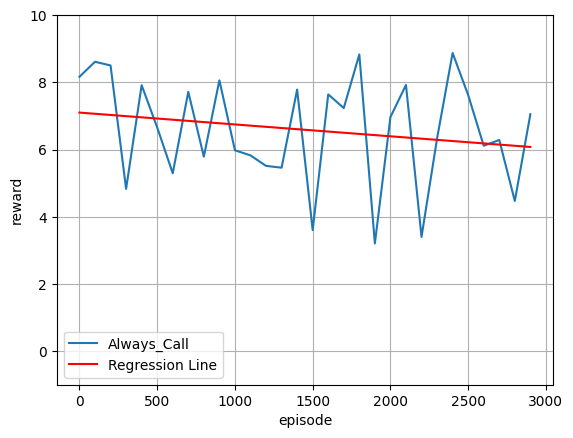

In [230]:
# Load CSV data
data = np.loadtxt(csv_path, delimiter=",", skiprows=1)
x = data[:, 0]
y = data[:, 1]
# Calculate regression line

coefficients = np.polyfit(x, y, 1)         
polynomial = np.poly1d(coefficients)
y_reg = polynomial(x)

# Plot learning curve
plot_curve(csv_path, fig_path, algorithm)

# Plot regression line
plt.plot(x, y_reg, color='r', label='Regression Line')
plt.ylim(-1, 10)  # Set y-axis limits
plt.legend()

# Save the combined plot to a different file
combined_fig_path = os.path.join(log_dir, f'{algorithm}_combined_plot.png')
plt.savefig(combined_fig_path)
plt.show()  # Show the plot after saving
plt.close()

In [202]:
#ts[3]['action_record'][-1][1].name
print(hand_played)

[(['HK', 'D4'], 'CHECK_CALL', 'PREFLOP', [99, 98], [<Action.FOLD: 0>, <Action.CHECK_CALL: 1>, <Action.RAISE_POT: 3>, <Action.ALL_IN: 4>]), (['HK', 'D4'], 'CHECK_CALL', 'PREFLOP', [96, 92], [<Action.FOLD: 0>, <Action.CHECK_CALL: 1>, <Action.RAISE_HALF_POT: 2>, <Action.RAISE_POT: 3>, <Action.ALL_IN: 4>]), (['HK', 'D4'], 'CHECK_CALL', 'PREFLOP', [90, 0], [<Action.FOLD: 0>, <Action.CHECK_CALL: 1>]), (['DQ', 'D8'], 'CHECK_CALL', 'PREFLOP', [99, 98], [<Action.FOLD: 0>, <Action.CHECK_CALL: 1>, <Action.RAISE_POT: 3>, <Action.ALL_IN: 4>]), (['DQ', 'D8'], 'CHECK_CALL', 'PREFLOP', [96, 92], [<Action.FOLD: 0>, <Action.CHECK_CALL: 1>, <Action.RAISE_HALF_POT: 2>, <Action.RAISE_POT: 3>, <Action.ALL_IN: 4>]), (['DQ', 'D8'], 'CHECK_CALL', 'PREFLOP', [90, 83], [<Action.FOLD: 0>, <Action.CHECK_CALL: 1>, <Action.RAISE_HALF_POT: 2>, <Action.RAISE_POT: 3>, <Action.ALL_IN: 4>]), (['DQ', 'D8'], 'CHECK_CALL', 'PREFLOP', [77, 0], [<Action.FOLD: 0>, <Action.CHECK_CALL: 1>]), (['C7', 'HJ'], 'FOLD', 'PREFLOP', [99

In [226]:
#folded_hands_played_last = folded_hands_played[-800:]
#folded_hands_played_begin = folded_hands_played[:800]

hands_only = [action[0] for action in hand_played] # Extract the hands played
action_made = [action[1] for action in hand_played] # Extract the actions made FOLD, CHECK_CALL, ...
stage_played = [action[2] for action in hand_played] # Extract the stage of the game PREFLOP, FLOP, TURN, RIVER
stakes_played = [action[3] for action in hand_played] # Extract the stakes played

print("During all the training, the model Always_Call has a:")
# Calculate the ratio of calling hands  played
raise_ratio_call = action_made.count("CHECK_CALL") / len(action_made)
print("Ratio of call hands played:", raise_ratio_call)
# Calculate the ratio of folded hands played
raise_ratio_fold = action_made.count("FOLD") / len(action_made)
print("Ratio of fold hands played:", raise_ratio_fold)
# Calculate the ratio of raised hands played
raise_ratio_raise = action_made.count("RAISE_POT") / len(action_made)
print("Ratio of raise hands played:", raise_ratio_raise)
# Calculate the ratio of all in hands played
raise_ratio_allin = action_made.count("ALL_IN") / len(action_made)
print("Ratio of all in hands played:", raise_ratio_allin)


Ratio of call hands played: 0.6136849607982894
Ratio of fold hands played: 0.3863150392017106
Ratio of raise hands played: 0.0
Ratio of all in hands played: 0.0


In [227]:
from collections import Counter
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
import os



# Flatten the list of lists
all_hands = [hand for sublist in hands_only for hand in sublist]

# Count the frequency of each hand
hand_counts = Counter(all_hands)

# Create bar plot data
data = go.Bar(
    x=list(hand_counts.keys()),
    y=list(hand_counts.values()),
    marker=dict(color='rgb(65, 131, 215)')
)

# Layout settings
layout = go.Layout(
    title='Frequency of Each Hand Played during the Flop',
    xaxis=dict(title='Hand'),
    yaxis=dict(title='Frequency'), 
    margin=dict(b=100),
)

# Create figure
fig = go.Figure(data=[data], layout=layout)

# Save the plot
plot_path = os.path.join(log_dir, f'{algorithm}_hand_frequency.html')
pio.write_html(fig, plot_path)

print('Frequency plot saved in', plot_path)


Frequency plot saved in ./logs/Always_Call_hand_frequency.html


In [231]:
from collections import Counter
import plotly.graph_objs as go
import plotly.io as pio
import os

# Function to check if the hand is a pair
def is_pair(hand):
    return len(hand) == 2 and len(hand[0]) > 1 and len(hand[1]) > 1 and hand[0][1] == hand[1][1]

# Function to check if 'A' is in one of the two cards
def has_ace(hand):
    return len(hand) == 2 and ((len(hand[0]) > 1 and 'A' in hand[0][1:]) or (len(hand[1]) > 1 and 'A' in hand[1][1:]))

# Function to check if the hand is a suited connector
def is_suited_connector(hand):
    if len(hand) != 2:
        return False
    suits = {'H', 'D', 'C', 'S'}
    ranks = {'2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K', 'A'}
    return hand[0][0] == hand[1][0] and (len(hand[0]) > 1 and hand[0][1:] in ranks) and (len(hand[1]) > 1 and hand[1][1:] in ranks)

# Function to check if the hand has specific combinations
def has_specific_combination(hand):
    ranks = {'KQ', 'KJ', 'KT', 'QJ', 'QT', 'JT'}
    return len(hand) == 2 and hand[0][1:] in ranks and hand[1][1:] in ranks

# Initialize counters
pair_count = 0
ace_count = 0
suited_connector_count = 0
specific_combinations_count = 0
others_count = 0

# Categorize hands
for hands in hands_only:
    if is_pair(hands):
        pair_count += 1
    elif has_ace(hands):
        ace_count += 1
    elif is_suited_connector(hands):
        suited_connector_count += 1
    elif has_specific_combination(hands):
        specific_combinations_count += 1
    else:
        others_count += 1

# Create data for the pie chart
labels = ['Pairs', "'A' in one card", 'Suited Connectors', 'Specific Combinations', 'Others']
values = [pair_count, ace_count, suited_connector_count, specific_combinations_count, others_count]

# Create the pie chart
data = go.Pie(labels=labels, values=values)

# Create layout
layout = go.Layout(
    title='Frequency of Each Type of Hand Played during the Flop'
)

# Create figure
fig = go.Figure(data=[data], layout=layout)

# Save the plot
plot_path = os.path.join(log_dir, f'{algorithm}_hand_type_frequency.html')
pio.write_html(fig, plot_path)

print('Frequency plot saved in', plot_path)

# Open the saved HTML file in Visual Studio Code
#webbrowser.open(plot_path)


Frequency plot saved in ./logs/Always_Call_hand_type_frequency.html


Now we also want to check the results of a semi optimal strategy to see if dqn is really better or not

--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  4.6435
----------------------------------------

----------------------------------------
  episode      |  100
  reward       |  6.256
----------------------------------------

----------------------------------------
  episode      |  200
  reward       |  4.7085
----------------------------------------

----------------------------------------
  episode      |  300
  reward       |  4.548
----------------------------------------

----------------------------------------
  episode      |  400
  reward       |  5.884
----------------------------------------

----------------------------------------
  episode      |  500
  reward       |  6.0565
----------------------------------------

----------------------------------------
  episode      |  600
  reward       |  5.1005
----------------------------------------

----------------------------------------
  episode      |  700
  reward

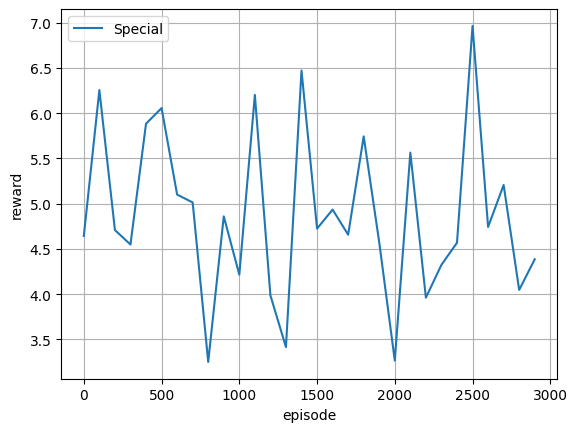

In [232]:
seed = 42

# Check whether gpu is available
device = get_device()
game_name = 'no-limit-holdem'
algorithm = 'Special'           #change the algorithm by dqn, Always_Call, Special
log_dir = './logs/'
num_episodes = 3000
evaluate_every = 100
num_eval_games = 2000         #
    
# Seed numpy, torch, random
set_seed(seed)

# Make the environment with seed
env = rlcard.make(
    game_name,
    config={
        'seed': seed
    }
)

# Initialize the agent and use random agents as opponents
if algorithm == 'dqn':
    from rlcard.agents import DQNAgent
    agent = DQNAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        mlp_layers=[64,64],
        device=device,
    )
elif algorithm == 'nfsp':
    from rlcard.agents import NFSPAgent
    agent = NFSPAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        hidden_layers_sizes=[64,64],
        q_mlp_layers=[64,64],
        device=device,
    )
elif algorithm == 'Always_Call':
    agent = Always_Call_Agent(num_actions=env.num_actions)

elif algorithm == 'Special':
    agent = SpecialAgent(num_actions=env.num_actions)
    

agents = [agent]
for _ in range(1, env.num_players):
    agents.append(RandomAgent(num_actions=env.num_actions))
env.set_agents(agents)


hand_played = []
#folded_hands_played = []
#raise_hands_played = []
# Start training
with Logger(log_dir) as logger:
    for episode in range(num_episodes):

        if algorithm == 'nfsp':
            agents[0].sample_episode_policy()

        # Generate data from the environment
        trajectories, payoffs = env.run(is_training=True)

        # Reorganaize the data to be state, action, reward, next_state, done
        trajectories = reorganize(trajectories, payoffs)

        # Feed transitions into agent memory, and train the agent
        # Here, we assume that DQN always plays the first position
        # and the other players play randomly (if any)
        for ts in trajectories[0]:
            agent.feed(ts)

        # Evaluate the performance. Play with random agents.
        if episode % evaluate_every == 0:
            logger.log_performance(
                episode,
                tournament(
                    env,
                    num_eval_games,
                )[0]
            )
        # Check if it's preflop and player didn't fold
        for ts in trajectories[0]:

            hand_played.append((ts[0]['raw_obs']['hand'],ts[3]['action_record'][-1][1].name, ts[0]['raw_obs']['stage'].name, ts[0]['raw_obs']['stakes'], ts[0]['raw_obs']['legal_actions'] ))
 




    # Get the paths
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the learning curve
plot_curve(csv_path, os.path.join(log_dir, f'{algorithm}_curve.png'), algorithm)

# Save model
save_path = os.path.join(log_dir, f'{algorithm}_model.pth')
torch.save(agent, save_path)
print('Model saved in', save_path)



We add a regression line to avoid the huge variance

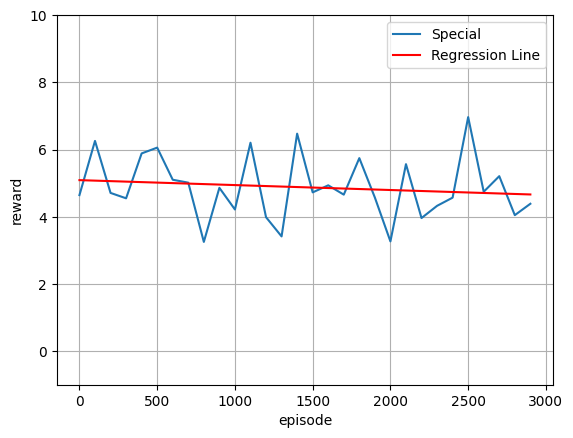

In [233]:
# Load CSV data
data = np.loadtxt(csv_path, delimiter=",", skiprows=1)
x = data[:, 0]
y = data[:, 1]
# Calculate regression line

coefficients = np.polyfit(x, y, 1)         
polynomial = np.poly1d(coefficients)
y_reg = polynomial(x)

# Plot learning curve
plot_curve(csv_path, fig_path, algorithm)

# Plot regression line
plt.plot(x, y_reg, color='r', label='Regression Line')
plt.ylim(-1, 10)  # Set y-axis limits
plt.legend()

# Save the combined plot to a different file
combined_fig_path = os.path.join(log_dir, f'{algorithm}_combined_plot.png')
plt.savefig(combined_fig_path)
plt.show()  # Show the plot after saving
plt.close()

In [234]:
#folded_hands_played_last = folded_hands_played[-800:]
#folded_hands_played_begin = folded_hands_played[:800]

hands_only = [action[0] for action in hand_played] # Extract the hands played
action_made = [action[1] for action in hand_played] # Extract the actions made FOLD, CHECK_CALL, ...
stage_played = [action[2] for action in hand_played] # Extract the stage of the game PREFLOP, FLOP, TURN, RIVER
stakes_played = [action[3] for action in hand_played] # Extract the stakes played

print("During all the training, the model Special has a:")
# Calculate the ratio of calling hands  played
raise_ratio_call = action_made.count("CHECK_CALL") / len(action_made)
print("Ratio of calling hands played:", raise_ratio_call)
# Calculate the ratio of folded hands played
raise_ratio_fold = action_made.count("FOLD") / len(action_made)
print("Ratio of folding hands played:", raise_ratio_fold)
# Calculate the ratio of raised hands played
raise_ratio_raise = action_made.count("RAISE_POT") / len(action_made)
print("Ratio of raising hands played:", raise_ratio_raise)
# Calculate the ratio of all in hands played
raise_ratio_allin = action_made.count("ALL_IN") / len(action_made)
print("Ratio of all in hands played:", raise_ratio_allin)


During all the training, the model Always_Call has a:
Ratio of call hands played: 0.40066289725092613
Ratio of fold hands played: 0.5993371027490739
Ratio of raise hands played: 0.0
Ratio of all in hands played: 0.0


In [235]:




# Flatten the list of lists
all_hands = [hand for sublist in hands_only for hand in sublist]

# Count the frequency of each hand
hand_counts = Counter(all_hands)

# Create bar plot data
data = go.Bar(
    x=list(hand_counts.keys()),
    y=list(hand_counts.values()),
    marker=dict(color='rgb(65, 131, 215)')
)

# Layout settings
layout = go.Layout(
    title='Frequency of Each Hand Played during the Flop',
    xaxis=dict(title='Hand'),
    yaxis=dict(title='Frequency'), 
    margin=dict(b=100),
)

# Create figure
fig = go.Figure(data=[data], layout=layout)

# Save the plot
plot_path = os.path.join(log_dir, f'{algorithm}_hand_frequency.html')
pio.write_html(fig, plot_path)

print('Frequency plot saved in', plot_path)


# Function to check if the hand is a pair
def is_pair(hand):
    return len(hand) == 2 and len(hand[0]) > 1 and len(hand[1]) > 1 and hand[0][1] == hand[1][1]

# Function to check if 'A' is in one of the two cards
def has_ace(hand):
    return len(hand) == 2 and ((len(hand[0]) > 1 and 'A' in hand[0][1:]) or (len(hand[1]) > 1 and 'A' in hand[1][1:]))

# Function to check if the hand is a suited connector
def is_suited_connector(hand):
    if len(hand) != 2:
        return False
    suits = {'H', 'D', 'C', 'S'}
    ranks = {'2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K', 'A'}
    return hand[0][0] == hand[1][0] and (len(hand[0]) > 1 and hand[0][1:] in ranks) and (len(hand[1]) > 1 and hand[1][1:] in ranks)

# Function to check if the hand has specific combinations
def has_specific_combination(hand):
    ranks = {'KQ', 'KJ', 'KT', 'QJ', 'QT', 'JT'}
    return len(hand) == 2 and hand[0][1:] in ranks and hand[1][1:] in ranks

# Initialize counters
pair_count = 0
ace_count = 0
suited_connector_count = 0
specific_combinations_count = 0
others_count = 0

# Categorize hands
for hands in hands_only:
    if is_pair(hands):
        pair_count += 1
    elif has_ace(hands):
        ace_count += 1
    elif is_suited_connector(hands):
        suited_connector_count += 1
    elif has_specific_combination(hands):
        specific_combinations_count += 1
    else:
        others_count += 1

# Create data for the pie chart
labels = ['Pairs', "'A' in one card", 'Suited Connectors', 'Specific Combinations', 'Others']
values = [pair_count, ace_count, suited_connector_count, specific_combinations_count, others_count]

# Create the pie chart
data = go.Pie(labels=labels, values=values)

# Create layout
layout = go.Layout(
    title='Frequency of Each Type of Hand Played during the Flop'
)

# Create figure
fig = go.Figure(data=[data], layout=layout)

# Save the plot
plot_path = os.path.join(log_dir, f'{algorithm}_hand_type_frequency.html')
pio.write_html(fig, plot_path)

print('Frequency plot saved in', plot_path)

# Open the saved HTML file in Visual Studio Code
#webbrowser.open(plot_path)


Frequency plot saved in ./logs/Special_hand_frequency.html
Frequency plot saved in ./logs/Special_hand_type_frequency.html


Now that we have everything, we add the option to play against the model

In [190]:
#in process...